In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy
from astropy import units as u, constants as const
from astropy.cosmology import Planck18
import utils1
import time as time
import emcee
import corner
from multiprocessing import Pool

In [2]:
run functions.py # ellipticity added

In [3]:
N_cells = 180 # number of cells of grid for convergence map
Lbox = 2. * u.Mpc
hext = 0.5*Lbox.to_value('Mpc') # half extent in Mpc
xedges = np.linspace(-hext, hext, N_cells+1)
yedges = np.linspace(-hext, hext, N_cells+1)
xs = 0.5*(xedges[1:]+xedges[:-1])
ys = 0.5*(yedges[1:]+yedges[:-1])
xgrid, ygrid = np.meshgrid(xs, ys, indexing='xy')
cosmo = astropy.cosmology.Planck18
z_lens = 0.072735
z_source = 0.1609
x0 = 0 # Mpc
y0 = 0 # Mpc

Dl = cosmo.angular_diameter_distance(z_lens)

kappa_cluster = kappa_cluster_NFW(xgrid=xgrid, ygrid=ygrid, x0=x0, y0=y0, c=3, M=18E15, z_lens=z_lens, z_source=z_source)

In [4]:
shear_cluster = shear_from_kappa(kappa=kappa_cluster)

In [5]:
def get_init(nwalkers):
    """ creates a list of initial values for c and mass nwalkers long
    """
    c = np.random.uniform(low=0.1, high=5.0, size=nwalkers)
    mass = np.random.uniform(low=18e13, high=18e16, size=nwalkers)
    x0 = np.random.uniform(low=-1, high=1, size=nwalkers)
    y0 = np.random.uniform(low=-1, high=1, size=nwalkers)
    p0 = []
    for i in range(nwalkers):
        p0.append(np.array([x0[i], y0[i], c[i], mass[i]]))
    return np.array(p0)

def log_prior(x):
    """ checking the guess is within range
    """
    x0,y0, c0, mass0 = x
    if not ((-1 < x0 < 1) and (-1 < y0 < 1) and (0.0 < c0 < 5.0) and (18e13 < mass0 < 18e16)):
        return -np.inf
    return 0.0

def log_prob(x, cluster: np.ndarray, sigma: float):
    """ x = p0 (initial guesses in the format of [(c, mass) * 50])
        sigma = std of cluster
    """ 
    # Check prior
    lp = log_prior(x)
    if not np.isfinite(lp):
        return -np.inf
    
    # Set values
    N_cells = 180 # number of cells of grid for convergence map
    Lbox = 2. * u.Mpc
    hext = 0.5*Lbox.to_value('Mpc') # half extent in Mpc
    xedges = np.linspace(-hext, hext, N_cells+1)
    yedges = np.linspace(-hext, hext, N_cells+1)
    xs = 0.5*(xedges[1:]+xedges[:-1])
    ys = 0.5*(yedges[1:]+yedges[:-1])
    xgrid, ygrid = np.meshgrid(xs, ys, indexing='xy')
    z_lens = 0.072735
    z_source = 0.1609
    
    # Create kappa and gamma maps
    x0,y0, c0, mass0 = x
    kappa = kappa_cluster_NFW(xgrid=xgrid, ygrid=ygrid, x0=x0, y0=y0, c=c0, M=mass0, z_lens=z_lens, z_source=z_source)
    gamma_model = shear_from_kappa(kappa)
    gamma_obs = cluster
    
    # Calculate residuals
    resid_real = (np.square(gamma_obs.real - gamma_model.real)) # 2D array
    resid_imag = (np.square(gamma_obs.imag - gamma_model.imag)) # 2D array
    term1 = np.sum(resid_real) # float
    term2 = np.sum(resid_imag) # float

    return -0.5 * (term1 + term2) / (sigma**2.) # float

In [6]:
nwalkers = 50
ndim = 4

p0 = get_init(nwalkers)

#noise = np.random.normal(0,0.05,np.shape(shear_cluster))
#cluster = shear_cluster + noise

In [7]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[shear_cluster + np.random.normal(0,0.05,np.shape(shear_cluster)), 0.05])
sampler.run_mcmc(p0, 1000, progress=True)

100%|██████████| 1000/1000 [12:02<00:00,  1.38it/s]


State([[ 2.93028553e-05  1.43488144e-03  2.99247135e+00  1.83379381e+16]
 [-3.33584214e-04 -6.36686340e-04  3.05006161e+00  1.77033548e+16]
 [ 4.89551036e-04 -2.10599063e-03  2.97158890e+00  1.80266965e+16]
 [ 1.94392587e-04 -4.41288857e-05  2.92585121e+00  1.82880595e+16]
 [ 1.57619572e-03 -2.19359467e-03  3.03402268e+00  1.75061094e+16]
 [ 9.08464962e-04 -1.02597898e-03  2.92537965e+00  1.88748117e+16]
 [ 1.71311693e-03 -6.99957964e-04  2.98177745e+00  1.77711249e+16]
 [ 1.74701671e-03  1.59069490e-03  3.00054665e+00  1.79351610e+16]
 [ 2.77122797e-04 -1.39729785e-03  3.00280472e+00  1.79887092e+16]
 [ 1.95690311e-04  3.19545401e-04  2.97376945e+00  1.81510568e+16]
 [ 1.23318268e-03  6.42582056e-04  2.96929513e+00  1.81456177e+16]
 [ 1.17568923e-03 -9.10471558e-04  2.96134356e+00  1.78911764e+16]
 [ 1.60842949e-03  7.28820085e-04  2.93552042e+00  1.84766638e+16]
 [ 2.43852102e-03  1.47689262e-03  2.91456922e+00  1.86049801e+16]
 [ 1.47622749e-03  3.42086965e-04  2.98955433e+00  1.813

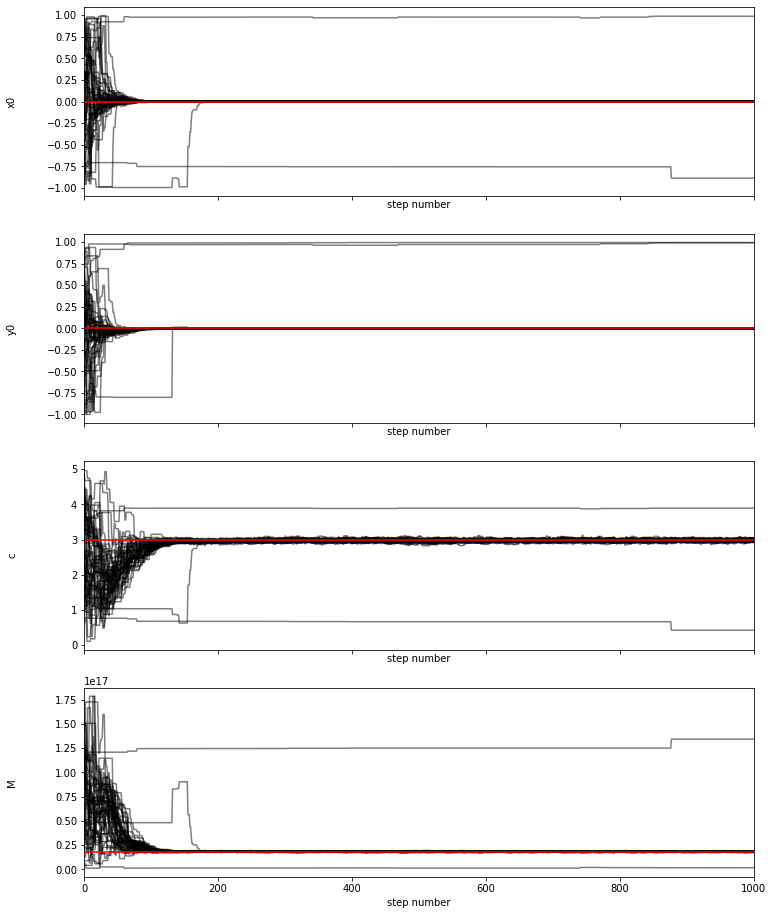

In [9]:
fig, axes = plt.subplots(4, figsize=(12, 16), sharex=True)
samples = sampler.get_chain()
labels = ["x0", "y0", "c", "M"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], color="k", alpha=0.5)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlabel("step number")
    if(i == 0):
        ax.axhline(0, color='r',alpha=1)
    elif(i == 1):
        ax.axhline(0, color='r',alpha=1)
    elif i == 2:
        ax.axhline(3, color='r',alpha=1)
    elif i == 3:
        ax.axhline(18E15, color='r',alpha=1)

burn-in: 108
thin: 10


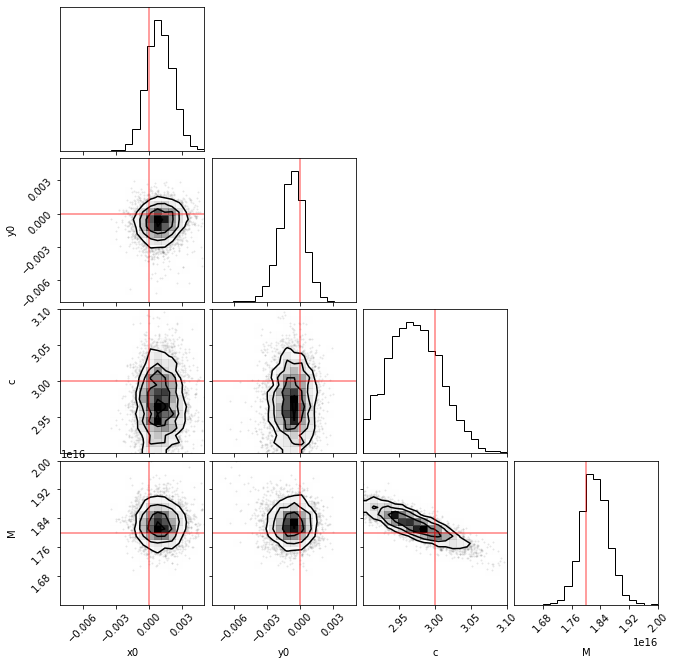

In [11]:
tau = [22.89383883, 20.16289866, 54.44434899, 52.29399834] #sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=False, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))

all_samples = np.concatenate(samples)

labels = ['x0', 'y0', 'c', 'M']

fig = corner.corner(all_samples, labels=labels, range=[(-0.008, 0.005), (-0.008, 0.005), (2.9, 3.1), (16e15, 20e15)]);
corner.overplot_lines(fig=fig, xs=[0, 0, 3, 18e15], color='red', alpha=0.5)

# redoing errors

In [ ]:
with Pool() as pool:
    sampler1 = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[shear_cluster + np.random.normal(0,0.01,np.shape(shear_cluster)), 0.01])
    sampler1.run_mcmc(p0, 1000, progress=True)
    
    sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[shear_cluster + np.random.normal(0,0.05,np.shape(shear_cluster)), 0.05])
    sampler2.run_mcmc(p0, 1000, progress=True)
    
    sampler3 = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[shear_cluster + np.random.normal(0,0.10,np.shape(shear_cluster)), 0.10])
    sampler3.run_mcmc(p0, 1000, progress=True)
    
    sampler4 = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[shear_cluster + np.random.normal(0,0.20,np.shape(shear_cluster)), 0.20])
    sampler4.run_mcmc(p0, 1000, progress=True)
    
    sampler5 = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[shear_cluster + np.random.normal(0,0.25,np.shape(shear_cluster)), 0.25])
    sampler5.run_mcmc(p0, 1000, progress=True)

 10%|▉         | 97/1000 [01:15<12:02,  1.25it/s]

In [11]:
from IPython.display import display, Math

## sampler1 (noise = 0.01)

In [ ]:
fig, axes = plt.subplots(4, figsize=(12, 16), sharex=True)
samples = sampler5.get_chain()
labels = ["x0", "y0", "c", "mass"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], color="k", alpha=0.5)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlabel("step number")
    if(i == 0):
        ax.axhline(0, color='r',alpha=1)
    elif(i == 1):
        ax.axhline(0, color='r',alpha=1)
    elif i == 2:
        ax.axhline(3, color='r',alpha=1)
    elif i == 3:
        ax.axhline(18E15, color='r',alpha=1)
        
for i in range(ndim):
    mcmc = np.percentile(samples[:, :, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3e}_{{-{1:.3e}}}^{{{2:.3e}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    print('std = ' + str(np.std(samples[:, :, i])))

burn-in: 122
thin: 10


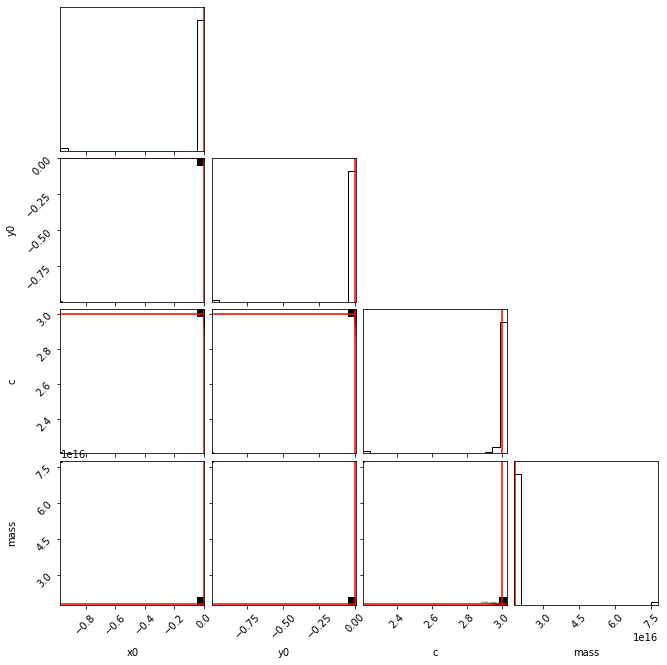

In [38]:
tau = [25.51379295, 20.70127226, 61.4297749,  54.41503265]
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler1.get_chain(discard=burnin, flat=False, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))

all_samples = np.concatenate(samples)

labels = ['x0', 'y0', 'c', 'mass']

fig = corner.corner(all_samples, labels=labels);
corner.overplot_lines(fig=fig, xs=[0, 0, 3, 18e15], color='red')

## sampler5 (noise = 0.25)

<IPython.core.display.Math object>

std = 0.16263598058702564


<IPython.core.display.Math object>

std = 0.1571477989456965


<IPython.core.display.Math object>

std = 0.49624336737017505


<IPython.core.display.Math object>

std = 1.3458252649154202e+16


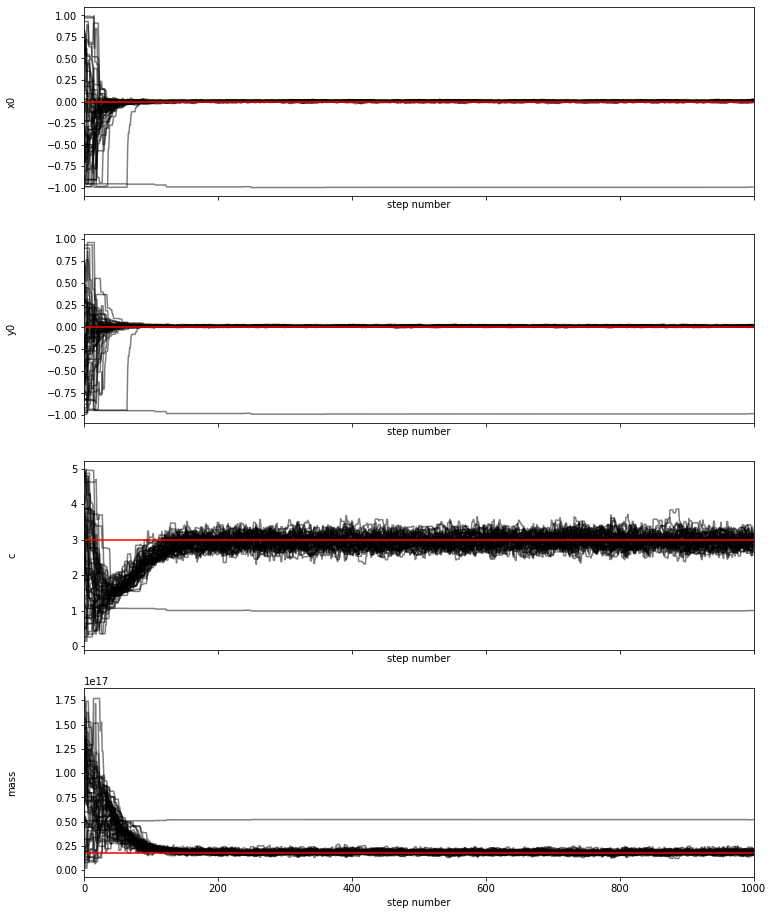

In [39]:
fig, axes = plt.subplots(4, figsize=(12, 16), sharex=True)
samples = sampler5.get_chain()
labels = ["x0", "y0", "c", "mass"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], color="k", alpha=0.5)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlabel("step number")
    if(i == 0):
        ax.axhline(0, color='r',alpha=1)
    elif(i == 1):
        ax.axhline(0, color='r',alpha=1)
    elif i == 2:
        ax.axhline(3, color='r',alpha=1)
    elif i == 3:
        ax.axhline(18E15, color='r',alpha=1)
        
for i in range(ndim):
    mcmc = np.percentile(samples[:, :, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3e}_{{-{1:.3e}}}^{{{2:.3e}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    print('std = ' + str(np.std(samples[:, :, i])))

burn-in: 137
thin: 10


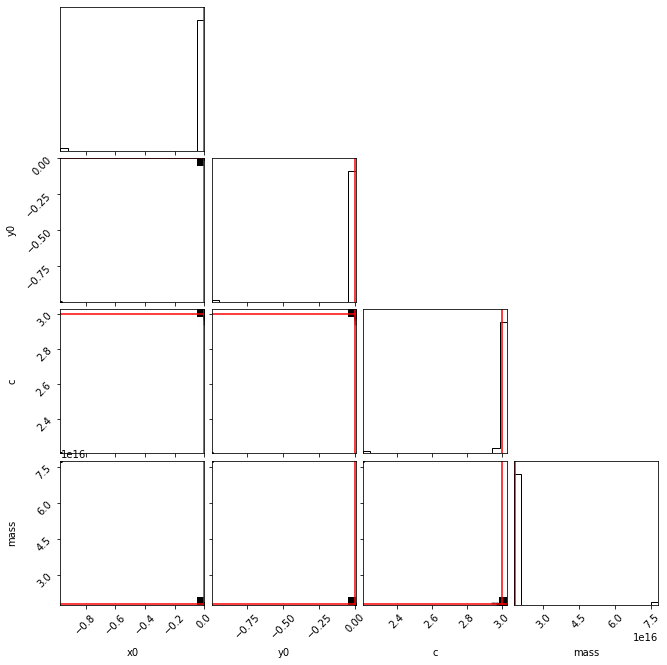

In [41]:
tau = [27.3515844,  21.99191541, 68.56433745, 61.06107844] #sampler5.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler1.get_chain(discard=burnin, flat=False, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))

all_samples = np.concatenate(samples)

labels = ['x0', 'y0', 'c', 'mass']

fig = corner.corner(all_samples, labels=labels);
corner.overplot_lines(fig=fig, xs=[0, 0, 3, 18e15], color='red')

## errors (std)

In [15]:
c_stds = []
m_stds = []
x0_stds = []
y0_stds = []
noises = [0.01, 0.05, 0.10, 0.20, 0.25]
all_samplers = [sampler1, sampler2, sampler3, sampler4, sampler5]

burnin = 400 

for i in range(len(all_samplers)):
    x0_stds.append(np.std(all_samplers[i].get_chain(discard=burnin, flat=False)[:, :, 0]))
    y0_stds.append(np.std(all_samplers[i].get_chain(discard=burnin, flat=False)[:, :, 1]))
    c_stds.append(np.std(all_samplers[i].get_chain(discard=burnin, flat=False)[:, :, 2]))
    m_stds.append(np.std(all_samplers[i].get_chain(discard=burnin, flat=False)[:, :, 3]))

Text(0, 0.5, 'Error in x0')

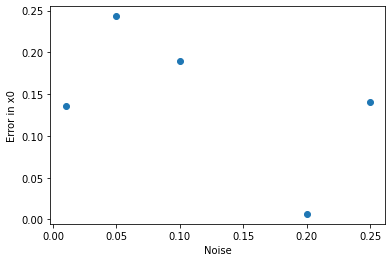

In [31]:
plt.plot(noises, x0_stds, 'o')
plt.xlabel('Noise')
plt.ylabel('Error in x0')

Text(0, 0.5, 'Error in y0')

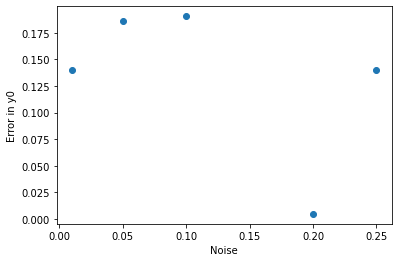

In [32]:
plt.plot(noises, y0_stds, 'o')
plt.xlabel('Noise')
plt.ylabel('Error in y0')

Text(0, 0.5, 'Error in c')

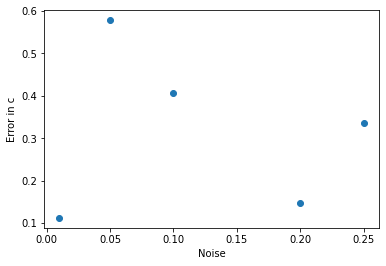

In [33]:
plt.plot(noises, c_stds, 'o')
plt.xlabel('Noise')
plt.ylabel('Error in c')

Text(0, 0.5, 'Error in mass')

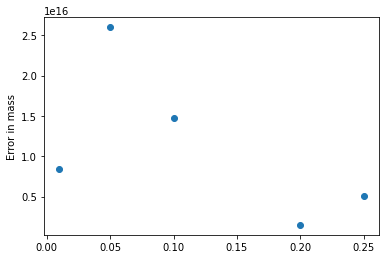

In [34]:
plt.plot(noises, m_stds, 'o')
plt.ylabel('Error in mass')

## error on the mean of the sample discarding burnin

In [10]:
all_x0 = []
all_y0 = []
all_c = []
all_m = []

for i in range(5):
    all_x0.append(np.array(all_samplers[i].get_chain()[:, :, 0]))
    all_y0.append(np.array(all_samplers[i].get_chain()[:, :, 1]))
    all_c.append(np.array(all_samplers[i].get_chain()[:, :, 2]))
    all_m.append(np.array(all_samplers[i].get_chain()[:, :, 3]))

NameError: name 'all_samplers' is not defined

In [11]:
for i in range(5):
    mean = np.mean(all_x0[i])
    plt.plot(noises[i], mean, marker='o', linestyle='none')
    plt.errorbar(noises[i], mean, yerr=x0_stds[i], fmt='none', color='orange')
    plt.xlabel('Noise')
    plt.ylabel('x0')

IndexError: list index out of range

In [12]:
for i in range(5):
    mean = np.mean(all_y0[i])
    plt.plot(noises[i], mean, marker='o', linestyle='none')
    plt.errorbar(noises[i], mean, yerr=y0_stds[i], fmt='none', color='orange')
    plt.xlabel('Noise')
    plt.ylabel('y0')

IndexError: list index out of range

In [13]:
for i in range(5):
    mean = np.mean(all_c[i])
    plt.plot(noises[i], mean, marker='o', linestyle='none')
    plt.errorbar(noises[i], mean, yerr=c_stds[i], fmt='none', color='orange')
    plt.xlabel('Noise')
    plt.ylabel('Concentration Parameter')

IndexError: list index out of range

In [14]:
for i in range(5):
    mean = np.mean(all_m[i])
    plt.plot(noises[i], mean, marker='o', linestyle='none')
    plt.errorbar(noises[i], mean, yerr=m_stds[i], fmt='none', color='orange')
    plt.xlabel('Noise')
    plt.ylabel('Mass')

IndexError: list index out of range